In [1]:
# Here we will try getting a prediction with LSTM using Keras

# Import key libraries
from help_lib import transform_dataframe, test_classifier, prepare_df
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Inputs
source_csv = '/home/andris/GitHub/data/user_teach_stuff.csv'
user_source = '/home/andris/GitHub/data/for_users.csv'

In [2]:
# Read csv into pandas dataframe
df = pd.read_csv(source_csv)
df = df.groupby(['user_id','event_leg']).sum()

# Extract the events that occured after user registration 
df_1 = df[df.index.get_level_values(1)>-1] # Activities following user registration

# --------------------------------------------------------------------
# Extract the events that happened before user registration, sum them and set event_leg at 0 
# --------------------------------------------------------------------

rep_features = ['grp_add_assig','grp_add_user','tch_add_assig','tch_add_user','tch_attempt','tch_create_group','tch_view_assig_prog']
month_array = range(int(min(df.index.get_level_values(1))),0)
df_2 = df[df.index.get_level_values(1).isin(month_array)]
df_2 = df_2.reset_index().groupby('user_id').sum()[rep_features]
df_2.columns = df_2.columns + '_tot'
df_2['event_leg'] = np.zeros(len(df_2.index))
df_2 = df_2.groupby(['user_id','event_leg']).sum()

# Add these new features to the user dataframe
for rep in rep_features:
    df_1[rep + '_tot'] = df_1[rep]
df_1 = df_1.add(df_2, fill_value=0)

# Do a cumulative sum on the features
for rep in rep_features:
    df_1[rep + '_tot'] = df_1.groupby('user_id')[rep + '_tot'].cumsum()
    
# --------------------------------------------------------------------
# Find the user churn from the users dataframe
# --------------------------------------------------------------------

# Loading the dataframe
df_user = pd.read_csv(user_source)
df_user = df_user.set_index('user_id')

# Determining the month of last activity
df_churn = np.floor((pd.to_datetime(df_user['last_seen'])  - pd.to_datetime(df_user['registration_date'])).dt.total_seconds()/(3600*24*30))
df_churn = df_churn.rename('churn_leg')

# Adding churn to the big dataframe
df = df_1.reset_index().set_index('user_id').join(df_churn)

# Eliminating events that occur after user churn
df = df[df['event_leg']<=df['churn_leg']]

# Cleaning up
df = df.drop('churn_leg',axis=1)
df = df.groupby(['user_id','event_leg']).sum()

# Printing finalised dataframe
df.head()

/home/andris/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


grp_add_assig  \
user_id                                            event_leg                  
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                  0.0   
                                                   1.0                  0.0   
                                                   2.0                  0.0   
                                                   3.0                  0.0   
                                                   4.0                  0.0   

                                                              grp_add_assig_tot  \
user_id                                            event_leg                      
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                      0.0   
                                                   1.0                      0.0   
                                                   2.0                      0.0   
                                                   3.0                      0.0   
                                                   4.0                      0.0   

                                                              grp_add_user  \
user_id                                            event_leg                 
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   2.0                 0.0   
                                                   3.0                 0.0   
                                                   4.0                 0.0   

                                                              grp_add_user_tot  \
user_id                                            event_leg                     
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   2.0                     0.0   
                                                   3.0                     0.0   
                                                   4.0                     0.0   

                                                              grp_added  \
user_id                                            event_leg              
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0              0.0   
                                                   1.0              0.0   
                                                   2.0              0.0   
                                                   3.0              0.0   
                                                   4.0              0.0   

                                                              play_video  \
user_id                                            event_leg               
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0               1.0   
                                                   1.0               0.0   
                                                   2.0               0.0   
                                                   3.0               0.0   
                                                   4.0               0.0   

                                                              q_lvl_0  \
user_id                                            event_leg            
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0          321.0   
                                                   1.0           50.0   
                                                   2.0          108.0   
                                                   3.0           34.0   
                                                   4.0           29.0   

                                                              q_lvl_0_cor  \
user_id                                            event_leg                
0009111939b7d071597369a67002b22853c08e19f463cf2... 0.0              137.0   
  

In [3]:
last_month = 4;
first_month = 1;

# Find users that have churned
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Remove rows before first month
df_lm = df_lm[df_lm.index.get_level_values(1)>=first_month]

# Display the dataframe
df_lm.head(10)

grp_add_assig  \
user_id                                            event_leg                  
0009111939b7d071597369a67002b22853c08e19f463cf2... 1.0                  0.0   
                                                   2.0                  0.0   
                                                   3.0                  0.0   
                                                   4.0                  0.0   
001209cc56f8583d638502e7446dd7461278082d613d4c6... 1.0                  1.0   
                                                   2.0                  0.0   
                                                   3.0                  0.0   
                                                   4.0                  0.0   
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45e... 1.0                  4.0   
                                                   2.0                 16.0   

                                                              grp_add_assig_tot  \
user_id                                            event_leg                      
0009111939b7d071597369a67002b22853c08e19f463cf2... 1.0                      0.0   
                                                   2.0                      0.0   
                                                   3.0                      0.0   
                                                   4.0                      0.0   
001209cc56f8583d638502e7446dd7461278082d613d4c6... 1.0                      6.0   
                                                   2.0                      6.0   
                                                   3.0                      0.0   
                                                   4.0                      6.0   
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45e... 1.0                     20.0   
                                                   2.0                     36.0   

                                                              grp_add_user  \
user_id                                            event_leg                 
0009111939b7d071597369a67002b22853c08e19f463cf2... 1.0                 0.0   
                                                   2.0                 0.0   
                                                   3.0                 0.0   
                                                   4.0                 0.0   
001209cc56f8583d638502e7446dd7461278082d613d4c6... 1.0                 0.0   
                                                   2.0                 0.0   
                                                   3.0                 0.0   
                                                   4.0                 0.0   
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45e... 1.0                 0.0   
                                                   2.0                40.0   

                                                              grp_add_user_tot  \
user_id                                            event_leg                     
0009111939b7d071597369a67002b22853c08e19f463cf2... 1.0                     0.0   
                                                   2.0                     0.0   
                                                   3.0                     0.0   
                                                   4.0                     0.0   
001209cc56f8583d638502e7446dd7461278082d613d4c6... 1.0                     5.0   
                                                   2.0                     5.0   
                                                   3.0                     0.0   
                                                   4.0                     5.0   
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45e... 1.0                    28.0   
                                                   2.0                    68.0   

                                                              grp_added  \
user_id                                            event_leg              
0009111939b7d071597369a67002b22853c08e19f463

In [4]:
df_lm = df_lm.reset_index()
df_lm['array'] = df_lm.drop(['user_id','event_leg'],axis=1).apply(tuple,axis=1).apply(list)
df_lm = df_lm.groupby('user_id').aggregate(lambda x: list(x))['array']

In [5]:
df_test = pd.Series(df_lm.values.tolist()).apply(np.asarray)

X_init = np.asarray(df_test)

X = np.hstack(X_init).reshape(len(df_test),len(df_test[0]),len(df_test[0][0]))
y = np.hstack(np.asarray(label)).reshape(len(X),1)

In [6]:
# Splitting training and test sets
from sklearn.model_selection import train_test_split

# Splitting into training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [7]:
### Building a neural network model

# Building the network model
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.models import Sequential
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

def create_model(input_length, input_dim):
    print ('Creating model...')
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='sigmoid', inner_activation='hard_sigmoid', input_shape = (input_length,input_dim)))
    model.add(Dense(1, activation='sigmoid'))


    print ('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.
/home/andris/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(label), label)
weight = {0:class_weight[0],1:class_weight[1]}
weight

{0: 0.56921995783555868, 1: 4.1116751269035534}

In [9]:
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
model = create_model(input_length, input_dim)

hist = model.fit(X_train,y_train, batch_size=128, epochs=3, verbose = 1,class_weight=weight)
#hist = model.fit(X_train,y_train, batch_size=128, epochs=10, verbose = 1)
y_score = model.predict_proba(X_test)
y_pred = model.predict_classes(X_test)

Creating model...


/home/andris/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation="sigmoid", input_shape=(4, 33), recurrent_activation="hard_sigmoid")`
  if sys.path[0] == '':


Compiling...
Epoch 1/3
3888/3888 [==============================] - 1s 236us/step - loss: 0.7072 - acc: 0.5617
Epoch 2/3
3888/3888 [==============================] - 1s 177us/step - loss: 0.7067 - acc: 0.4321
Epoch 3/3
3888/3888 [==============================] - 1s 182us/step - loss: 0.7004 - acc: 0.5288


(array([ 863.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  109.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

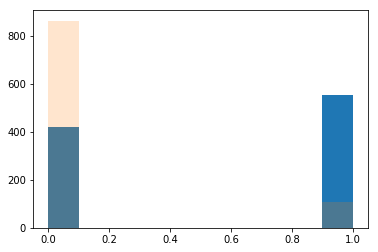

In [10]:
plt.hist(y_pred)
plt.hist(y_test, alpha=0.2)


In [11]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.90      0.44      0.59       863
          1       0.12      0.61      0.20       109

avg / total       0.81      0.46      0.54       972



0.512836595193


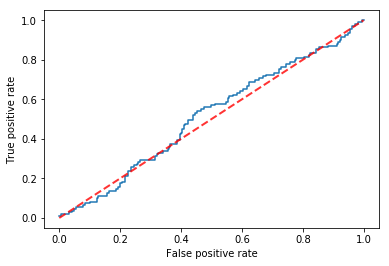

In [12]:
# Let's plot an ROC curve
fpr, tpr, thresholds = roc_curve(y_test,y_score)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

print(roc_auc_score(y_test,y_score))